In [1]:
# limit the thread used by numpy for better parallelization
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# import logging

# sys.path.append("..")
from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import *
from Triangle.Interferometer import *
from Triangle.TDI import *
from Triangle.Glitch import *
from Triangle.GW import *

try:
    import cupy as xp
    # print("Has Cupy")
    # HAS_GPU = True
except ImportError:
    import numpy as xp
    # print("No Cupy")
    # HAS_GPU = False

no cupy 


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


## General implementation 

In [3]:
# set the TCB times of resulting TDI responses
# t_start = 10 * DAY 
t_start = 0 
Tobs = 100 * DAY
dt = 5.
tcb_times = np.arange(int(Tobs / dt)) * dt + t_start

# orbit model
orbit = Orbit(OrbitDir="../OrbitData/MicroSateOrbitEclipticTCB")

tcb_times[0] / DAY, tcb_times[-1] / DAY 

(0.0, 99.99994212962963)

In [4]:
approximant = "IMRPhenomTHM"
# approximant = "SEOBNRv4_opt"

mbhb_waveform_generator = MBHB_Injection(approx_method=approximant, buffer=True)

mbhb_response_generator = GeneralTDIResponse(
    orbit=orbit,
    Pstring=GeneralTDIResponse.X2_strings,
    tcb_times=tcb_times.copy(),
    use_gpu=False,
    drop_points=int(1000 / dt),
    linear_interp=False,
    return_eta=False, 
)

In [5]:
MBHB_params1 = {
    "chirp_mass": 1000000.0,
    "mass_ratio": 0.3640815267051051,
    "spin_1z": 0.7899406190510447,
    "spin_2z": 0.015424596359292053,
    "coalescence_time": tcb_times[-1] / DAY - 10.,
    "coalescence_phase": 3.2535342675592966,
    "luminosity_distance": 106039.10941463517,
    "inclination": 1.4495086550199021,
    "longitude": 3.032776598141215,
    "latitude": -1.1817968279048852,
    "psi": 0.2409146690555858,
}

MBHB_params2 = MBHB_params1.copy()
MBHB_params2["coalescence_phase"] += 1.

In [6]:
X2_general1 = mbhb_response_generator(parameters=MBHB_params1, waveform_generator=mbhb_waveform_generator)
t_end_detector1 = SSBTimetoDetectorTime(time_ssb=mbhb_waveform_generator.tend, orbit=orbit, longitude=MBHB_params1["longitude"], latitude=MBHB_params1["latitude"])

X2_general2 = mbhb_response_generator(parameters=MBHB_params2, waveform_generator=mbhb_waveform_generator)
t_end_detector2 = SSBTimetoDetectorTime(time_ssb=mbhb_waveform_generator.tend, orbit=orbit, longitude=MBHB_params2["longitude"], latitude=MBHB_params2["latitude"])


In [7]:
# remove_idx = np.where(tcb_times > t_end_detector1 - MBHB_params1["chirp_mass"] / 1e6)[0]
# X2_general1[remove_idx] *= 0. 

# remove_idx = np.where(tcb_times > t_end_detector2 - MBHB_params2["chirp_mass"] / 1e6)[0]
# X2_general2[remove_idx] *= 0. 

(89.94994212962963, 90.04994212962963)

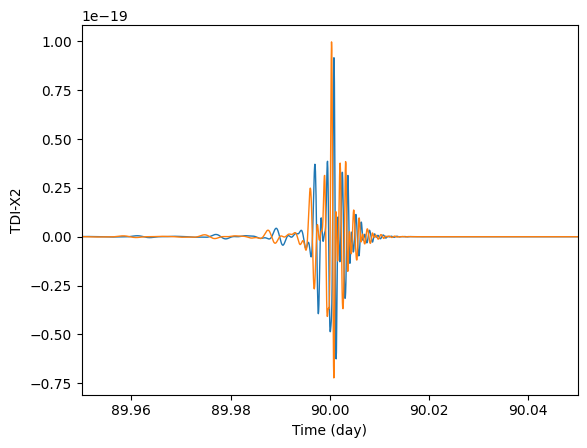

In [8]:
plt.plot(tcb_times / DAY, X2_general1, linewidth=1)
plt.plot(tcb_times / DAY, X2_general2, linewidth=1)
# plt.plot(tcb_times / DAY, X2_general1 - X2_general2, linewidth=1)
plt.xlabel("Time (day)")
plt.ylabel("TDI-X2")
# plt.ylim(-1e-23, 1e-23)
plt.xlim(MBHB_params1["coalescence_time"] - 0.05, MBHB_params1["coalescence_time"] + 0.05)

## Faster implementation 

In [9]:
mbhb_mich_generator = FastMichelsonTDIResponse(
    orbit=orbit, 
    tcb_times=tcb_times.copy(), 
    use_gpu=False, 
    drop_points=int(1000./dt), 
    interp_method="Spline5", 
    # interp_method="Spline3",
    # interp_method="Akima",
    # interp_method="linear",
    # waveform_interp_order=5,
)

In [10]:
X2_fastmich1, _, _ = mbhb_mich_generator(parameters=MBHB_params1, waveform_generator=mbhb_waveform_generator, optimal_combination=False)
X2_fastmich2, _, _ = mbhb_mich_generator(parameters=MBHB_params2, waveform_generator=mbhb_waveform_generator, optimal_combination=False)

(89.94994212962963, 90.04994212962963)

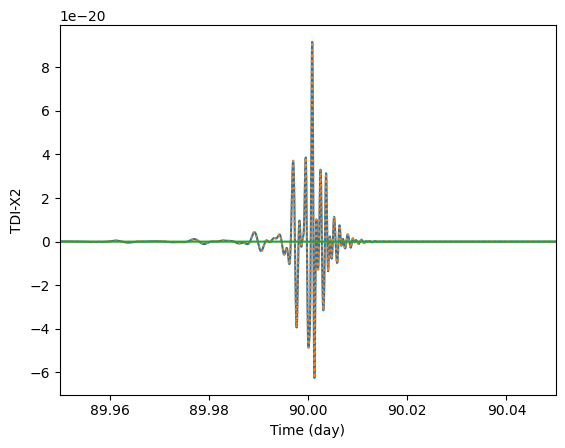

In [11]:
plt.plot(tcb_times / DAY, X2_general1)
plt.plot(tcb_times / DAY, X2_fastmich1, linestyle=":")
plt.plot(tcb_times / DAY, X2_general1 - X2_fastmich1)
plt.xlabel("Time (day)")
plt.ylabel("TDI-X2")
# plt.ylim(-1e-23, 1e-23)
plt.xlim(MBHB_params1["coalescence_time"] - 0.05, MBHB_params1["coalescence_time"] + 0.05)

(1e-05, 1)

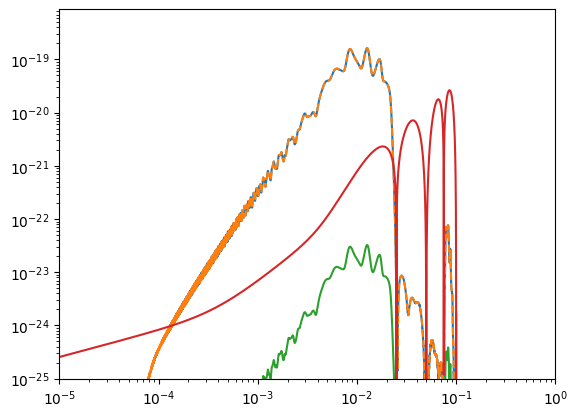

In [12]:
ff, xf = FFT_window(X2_general1, 1./dt)
plt.loglog(ff, np.abs(xf) * 2. * ff)

ff, xf1 = FFT_window(X2_fastmich1, 1./dt)
plt.loglog(ff, np.abs(xf1) * 2. * ff, linestyle="--")

plt.loglog(ff, np.abs(xf - xf1) * 2. * ff)

PSDfunc = TDIPSDs() 
plt.loglog(ff, np.sqrt(PSDfunc.PSD_X2(ff) * ff))

plt.ylim(1e-25,)
plt.xlim(1e-5, 1)

(89.94994212962963, 90.04994212962963)

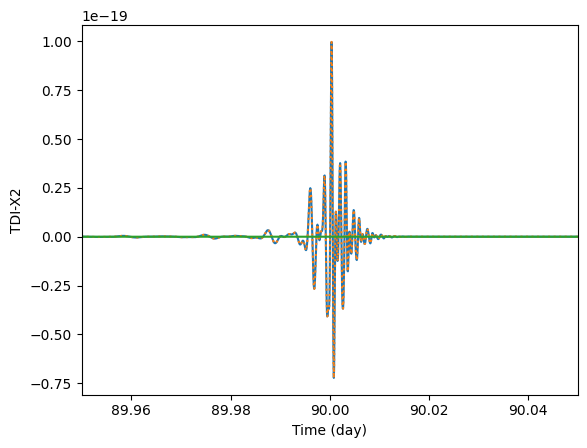

In [13]:
plt.plot(tcb_times / DAY, X2_general2)
plt.plot(tcb_times / DAY, X2_fastmich2, linestyle=":")
plt.plot(tcb_times / DAY, X2_general2 - X2_fastmich2)
plt.xlabel("Time (day)")
plt.ylabel("TDI-X2")
# plt.ylim(-1e-23, 1e-23)
plt.xlim(MBHB_params2["coalescence_time"] - 0.05, MBHB_params2["coalescence_time"] + 0.05)

(1e-05, 1)

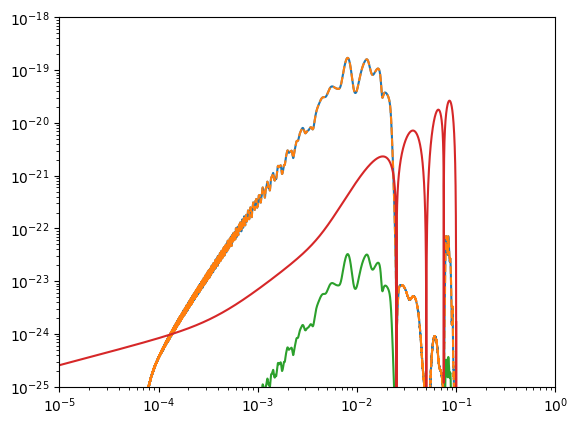

In [14]:
ff, xf = FFT_window(X2_general2, 1./dt)
plt.loglog(ff, np.abs(xf) * 2. * ff)

ff, xf1 = FFT_window(X2_fastmich2, 1./dt)
plt.loglog(ff, np.abs(xf1) * 2. * ff, linestyle="--")

plt.loglog(ff, np.abs(xf - xf1) * 2. * ff)

PSDfunc = TDIPSDs() 
plt.loglog(ff, np.sqrt(PSDfunc.PSD_X2(ff) * ff))

plt.ylim(1e-25,)
plt.xlim(1e-5, 1)

## Compare speed across waveforms 

In [40]:
test_times = np.arange(int(30*DAY / 5.)) * 5. + 30 * DAY

mbhb_mich_generator = FastMichelsonTDIResponse(
    orbit=orbit, 
    tcb_times=test_times.copy(), 
    use_gpu=False, 
    drop_points=int(1000./dt), 
    interp_method="Spline5", 
    # interp_method="Spline3",
    # interp_method="Akima",
    # interp_method="linear",
    # waveform_interp_order=5,
)

MBHB_params1 = {
    "chirp_mass": 1000000.0,
    "mass_ratio": 0.3640815267051051,
    "spin_1z": 0.7899406190510447,
    "spin_2z": 0.015424596359292053,
    "coalescence_time": test_times[-1] / DAY - 5.,
    "coalescence_phase": 3.2535342675592966,
    "luminosity_distance": 106039.10941463517,
    "inclination": 1.4495086550199021,
    "longitude": 3.032776598141215,
    "latitude": -1.1817968279048852,
    "psi": 0.2409146690555858,
}

In [50]:
mbhb_waveform_generator_eob4 = MBHB_Injection(approx_method="SEOBNRv4_opt", buffer=True)
mbhb_waveform_generator_eob4HM = MBHB_Injection(approx_method="SEOBNRv4HM", buffer=True)

mbhb_waveform_generator_pnmT = MBHB_Injection(approx_method="IMRPhenomT", buffer=True)
mbhb_waveform_generator_pnmTHM = MBHB_Injection(approx_method="IMRPhenomTHM", buffer=True)

mbhb_waveform_generator_pnmD = MBHB_Injection(approx_method="IMRPhenomD", buffer=True)
mbhb_waveform_generator_pnmHM = MBHB_Injection(approx_method="IMRPhenomXHM", buffer=True)


In [42]:
for i in tqdm(range(5)):    
    x_eob4, _, _ = mbhb_mich_generator(parameters=MBHB_params1, waveform_generator=mbhb_waveform_generator_eob4, optimal_combination=False)

100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


In [43]:
for i in tqdm(range(5)):    
    x_eob4HM, _, _ = mbhb_mich_generator(parameters=MBHB_params1, waveform_generator=mbhb_waveform_generator_eob4HM, optimal_combination=False)

100%|██████████| 5/5 [00:57<00:00, 11.56s/it]


In [44]:
for i in tqdm(range(5)):    
    x_pnmT, _, _ = mbhb_mich_generator(parameters=MBHB_params1, waveform_generator=mbhb_waveform_generator_pnmT, optimal_combination=False)

100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


In [45]:
for i in tqdm(range(5)):    
    x_pnmTHM, _, _ = mbhb_mich_generator(parameters=MBHB_params1, waveform_generator=mbhb_waveform_generator_pnmTHM, optimal_combination=False)

100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


In [46]:
for i in tqdm(range(5)):    
    x_pnmD, _, _ = mbhb_mich_generator(parameters=MBHB_params1, waveform_generator=mbhb_waveform_generator_pnmD, optimal_combination=False)

100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


In [51]:
for i in tqdm(range(5)):    
    x_pnmHM, _, _ = mbhb_mich_generator(parameters=MBHB_params1, waveform_generator=mbhb_waveform_generator_pnmHM, optimal_combination=False)

100%|██████████| 5/5 [00:23<00:00,  4.61s/it]


(54.94994212962963, 55.04994212962963)

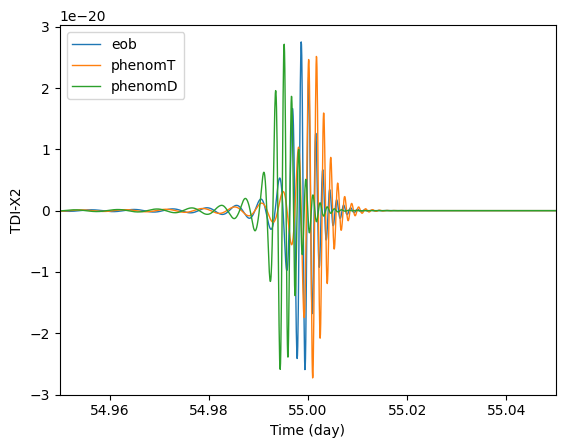

In [52]:
plt.plot(test_times / DAY, x_eob4, label="eob", linewidth=1)
plt.plot(test_times / DAY, x_pnmT, label="phenomT", linewidth=1)
plt.plot(test_times / DAY, x_pnmD, label="phenomD", linewidth=1)
plt.xlabel("Time (day)")
plt.ylabel("TDI-X2")
plt.legend(loc="upper left")
plt.xlim(MBHB_params1["coalescence_time"] - 0.05, MBHB_params1["coalescence_time"] + 0.05)
# plt.ylim(-1e-23, 1e-23)

(54.94994212962963, 55.04994212962963)

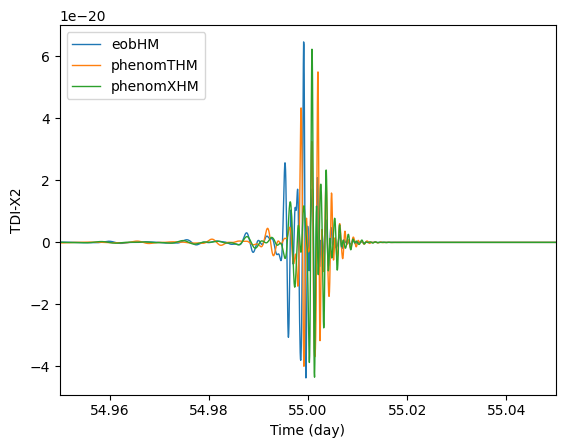

In [53]:
plt.plot(test_times / DAY, x_eob4HM, label="eobHM", linewidth=1)
plt.plot(test_times / DAY, x_pnmTHM, label="phenomTHM", linewidth=1)
plt.plot(test_times / DAY, x_pnmHM, label="phenomXHM", linewidth=1)
plt.xlabel("Time (day)")
plt.ylabel("TDI-X2")
plt.legend(loc="upper left")
plt.xlim(MBHB_params1["coalescence_time"] - 0.05, MBHB_params1["coalescence_time"] + 0.05)
# plt.ylim(-1e-23, 1e-23)